# Model selection

In this notebook I will elaborate on the hypotezis that it is enough to train a simple NN or linear classifier to predict rankings of films. I will try to select an appropriate model and then fine-tune it.

In [2]:
import pandas as pd
import sys
import os
sys.path.append("../")
from definitions import ROOT_DIR
import numpy as np

## Data splitting

In [3]:
data_folder = os.path.join(ROOT_DIR, 'data/interim')

In [4]:
data = pd.read_csv(os.path.join(data_folder, 'all.csv'))

In [5]:
data.head(2)

,rating,release_date,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,...,Washington,West Virginia,Wisconsin,Wyoming,0-18,18-27,27-35,35-42,42-55,55+
0,3,0.534335,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
1,3,0.534335,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0


In [6]:
y = data['rating'].to_numpy()
X = data.drop('rating', axis=1, errors='ignore').to_numpy()
X.shape, y.shape

((100000, 103), (100000,))

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Linear classifier

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import 

In [16]:
model = LinearRegression(n_jobs=-1)
model.fit(X_train, y_train)
print("Train RMSE:", mean_squared_error(y_train, model.predict(X_train), squared=False))
print("Test RMSE:", mean_squared_error(y_test, model.predict(X_test), squared=False))

Train RMSE: 1.0752317794463297
Test RMSE: 1.0770118583133976


## Neural network

In [17]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from torch import optim

In [24]:
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train) - 1
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test) - 1

In [37]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [55]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size * 2)
        self.fc3 = nn.Linear(hidden_size * 2, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

In [64]:
input_size = 103
hidden_size = 256
output_size = 1
model = NeuralNet(input_size, hidden_size, output_size)

In [65]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

train_losses = []
test_losses = []

In [66]:
num_epochs = 40

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs).view(-1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    model.eval()
    test_running_loss = 0.0

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            outputs = model(inputs).view(-1)
            loss = criterion(outputs, labels)
            test_running_loss += loss.item()

    train_loss = running_loss/len(train_loader)
    test_loss = test_running_loss/len(test_loader)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    print(f"Epoch {epoch+1}/{num_epochs}\t train loss: {train_loss}\t test loss: {test_loss}")

Epoch 1/40	 train loss: 1.2439557705640794	 test loss: 1.1577606256484985
Epoch 2/40	 train loss: 1.1733106945753098	 test loss: 1.1420368980407716
Epoch 3/40	 train loss: 1.148613222181797	 test loss: 1.1325244441986084
Epoch 4/40	 train loss: 1.13296238322258	 test loss: 1.119676858997345
Epoch 5/40	 train loss: 1.1207789078950883	 test loss: 1.1228706407546998
Epoch 6/40	 train loss: 1.1083762514829636	 test loss: 1.1028995717048644
Epoch 7/40	 train loss: 1.0943381805181502	 test loss: 1.0931932319641113
Epoch 8/40	 train loss: 1.0835800209164619	 test loss: 1.0965643734931947
Epoch 9/40	 train loss: 1.0738878680586814	 test loss: 1.1001841321468353
Epoch 10/40	 train loss: 1.066188222670555	 test loss: 1.0759291463851928
Epoch 11/40	 train loss: 1.0574532034993172	 test loss: 1.0707025379657746
Epoch 12/40	 train loss: 1.0532553099751472	 test loss: 1.073729895067215
Epoch 13/40	 train loss: 1.0496060789585113	 test loss: 1.0949670374393463
Epoch 14/40	 train loss: 1.0445970900893

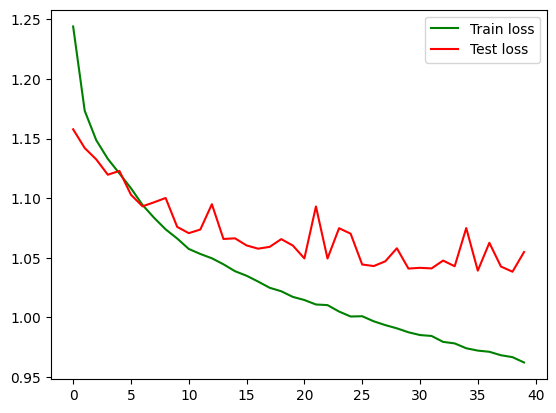

In [67]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Train loss', color='green')
plt.plot(test_losses, label='Test loss', color='red')
plt.legend()
plt.show()

In [68]:
# Evaluation on the test set
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = torch.round(model(inputs)).view(-1)
        total += labels.size(0)
        correct += (outputs == labels).sum().item()

accuracy = correct / total
print(f"Test Accuracy: {accuracy}")

Test Accuracy: 0.375


## Analyzing results

As we can see, this straightforward approach does not perform well (I have tried many NN architectures, regularizations, etc). We can clearly see that model can find train-specific patterns, but this patterns are not common, so the model just overfits. I believe this is because these models do not analyze data about a certain user or film, while it is essential to analyze each particular user info and ratings separately.

**Now I will try a different approach** to solve this task. I will engineer data again in '3.1-data-engineering.ipynb', train another model in '4.1-model-selection' and etc.